In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import plotting
import matplotlib.style
import matplotlib.ticker as ticker

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
shuffled_experiments = "(hostname == 'scyper21')" ## Scyper21 was used for experiments that loaded the graph in shuffled order
ordered_experiments = "(hostname == 'scyper22')" ## Scyper22 was used for experiments that loaded the graph in sorted order

libraries = ["sortledton.4", "g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "stinger7-ref", "teseo-lcc.12"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22",
              "uniform-24", "uniform-26", "edit-enwiki.el", "yahoo-song.el"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853, 255689125, 256771317]
})

data_ordered = common.import_gfe_dbms("View_Inserts", "data/new.sqlite3").query(ordered_experiments).copy() # data from the experiments
data_ordered['ordering'] = 'timestamp'
data_shuffled = common.import_gfe_dbms("View_Inserts", "data/new.sqlite3").query(shuffled_experiments).copy()
data_shuffled['ordering'] = 'random'

data = pd.concat([data_ordered, data_shuffled])

data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data["block_size"].fillna(-1, inplace=True)

In [3]:
data = data.query("((block_size == 512) and library == 'sortledton.4') or library != 'sortledton.4'") 
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data = data.query(libraries_filter)
data = data.query("graph == 'yahoo-song.el' or graph == 'edit-enwiki.el'")

In [13]:
# Filter library by threads
threading_query = "(num_threads == 56 and library in ['sortledton.4', 'g1_v6-ref-ignore-build', 'stinger7-ref'])"
threading_query += " or (num_threads == 20 or num_threads == 16 and library in ['livegraph3_ro'])"
threading_query += " or (num_threads == 16 and library in ['llama8-ref'])"
data = data.query(threading_query)

In [15]:
data_grouped = data.groupby(["graph", "ordering", "library"]) \
    .agg(std_eps=("edges_per_second", "std"), edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
data_grouped["cov"] = data_grouped["std_eps"] / data_grouped["edges_per_second"]
data_grouped.drop(["std_eps"], axis=1, inplace=True)
data_grouped

edges_per_second  count  \
graph          ordering  library                                           
edit-enwiki.el random    g1_v6-ref-ignore-build      2.166164e+06      1   
                         livegraph3_ro               3.033236e+05      3   
                         sortledton.4                3.436918e+06      1   
               timestamp g1_v6-ref-ignore-build      3.752407e+05      2   
                         sortledton.4                5.977732e+05      5   
yahoo-song.el  random    g1_v6-ref-ignore-build      3.383912e+06      1   
                         livegraph3_ro               3.516672e+05      2   
                         llama8-ref                  2.053117e+05      2   
                         sortledton.4                3.537807e+06      1   
                         stinger7-ref                3.364155e+04      1   
               timestamp g1_v6-ref-ignore-build      2.561384e+06      2   
                         livegraph3_ro               9.729530e+04      1   
                         llama8-ref                  7.753096e+04      1   
                         sortledton.4                6.819061e+05      2   
                         stinger7-ref                3.559977e+04      2   

                                                      cov  
graph          ordering  library                           
edit-enwiki.el random    g1_v6-ref-ignore-build       NaN  
                         livegraph3_ro           0.041264  
                         sortledton.4                 NaN  
               timestamp g1_v6-ref-ignore-build  0.033908  
                         sortledton.4            0.004744  
yahoo-song.el  random    g1_v6-ref-ignore-build       NaN  
                         livegraph3_ro           0.035394  
                         llama8-ref              0.002073  
                         sortledton.4                 NaN  
                         stinger7-ref                 NaN  
               timestamp g1_v6-ref-ignore-build  0.034691  
                         livegraph3_ro                NaN  
                         llama8-ref                   NaN  
                         sortledton.4            0.003226  
                         stinger7-ref            0.000462

In [16]:
data_pivot = data_grouped.reset_index().pivot(index=["graph", "ordering"], values=["edges_per_second"], columns="library")
data_pivot = data_pivot[[("edges_per_second", "sortledton.4"), 
                         ("edges_per_second", "g1_v6-ref-ignore-build"),
                         ("edges_per_second", "stinger7-ref"),
                         ("edges_per_second", "llama8-ref"),
                         ("edges_per_second", "livegraph3_ro"),
                        ]]
data_pivot

edges_per_second                         \
library                      sortledton.4 g1_v6-ref-ignore-build   
graph          ordering                                            
edit-enwiki.el random        3.436918e+06           2.166164e+06   
               timestamp     5.977732e+05           3.752407e+05   
yahoo-song.el  random        3.537807e+06           3.383912e+06   
               timestamp     6.819061e+05           2.561384e+06   

                                                                      
library                   stinger7-ref     llama8-ref  livegraph3_ro  
graph          ordering                                               
edit-enwiki.el random              NaN            NaN  303323.609747  
               timestamp           NaN            NaN            NaN  
yahoo-song.el  random     33641.548950  205311.709167  351667.215347  
               timestamp  35599.773559   77530.961805   97295.297144

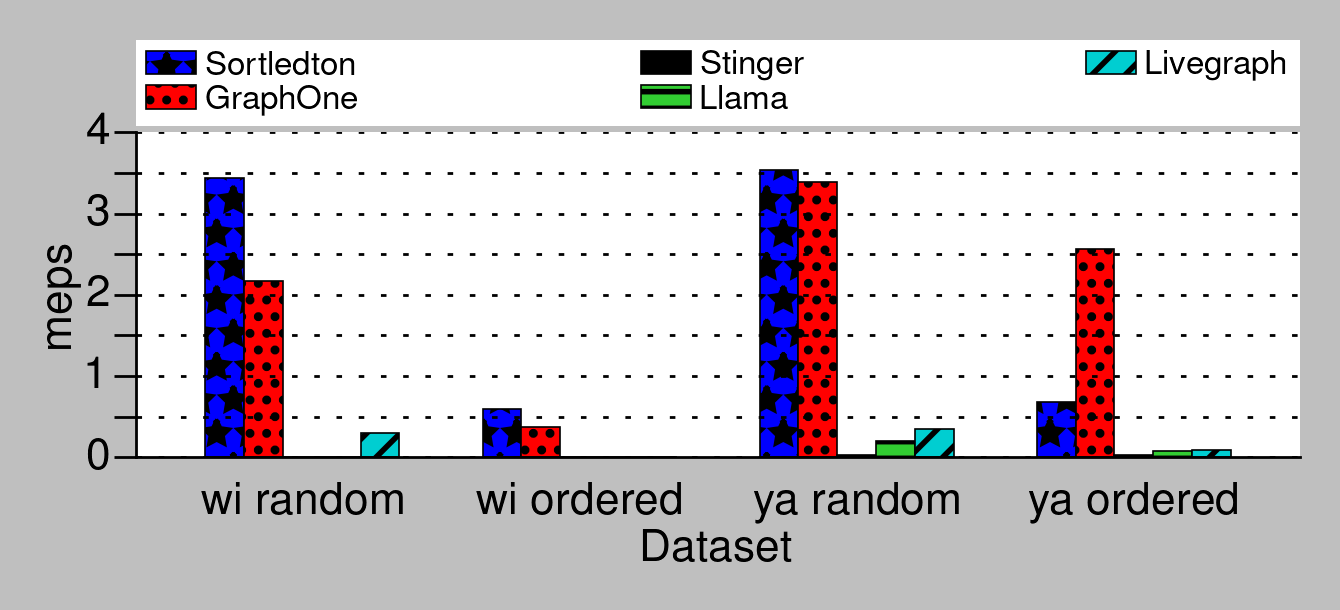

In [17]:
matplotlib.style.use('classic')

color_dict = {('edges_per_second', 'g1_v6-ref-ignore-build'):'red',
                  ('edges_per_second', 'sortledton.4'):'blue',
                  ('edges_per_second', 'llama8-ref'):'limegreen',
                  ('edges_per_second', 'teseo-lcc.12'):'mediumorchid',
                  ('edges_per_second', 'stinger7-ref'):'black',
                  ('edges_per_second', 'livegraph3_ro'):'darkturquoise',
                  }

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y) if x / scale_y == round(x/scale_y) else None)

plotting.latexify(columns=2, fig_height=plotting.cm2inch(4))

p = data_pivot.plot.bar(width=0.7, linewidth=0.3, color=color_dict)

plt.ylabel("meps")
plt.xlabel("Dataset")

positions = (0, 1, 2, 3)
x_labels = ("wi random", "wi ordered", "ya random", "ya ordered")
plt.xticks(positions, x_labels)
plt.xticks(rotation=0)

p.yaxis.set_major_formatter(ticks_y)
plt.yticks()

plotting.apply_hatches(['sortledton', 'graphone', 'stinger', 'llama', 'livegraph'], 4, 0, p.patches)

legend_labels = ["Sortledton", "GraphOne", "Stinger", "Llama", "Livegraph"]
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., labels=legend_labels).get_frame().set_linewidth(0.0)

plotting.format_axes(p, categorical_x=True)
p.yaxis.grid(which="minor",b=None)

plt.tight_layout()
plt.savefig(plotting.base_path + "insertions-real-workload.png", dpi=400)